In [1]:
import numpy as np
import uproot as ur
import ROOT as rt
import root_numpy as rtnp
import ROOT.RooFit as rf
from scipy.special import erf
from histo_utilities import create_TH1D, create_TH2D, std_color_list
from cebefo_style import Set_2D_colz_graphics

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Preliminary"

donotdelete = []

Welcome to JupyROOT 6.10/08


In [2]:
from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel

In [3]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

# Data loading

In [4]:
tMC = ur.open('../data/cmsMC_private/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_SoftQCD_PTFilter5_0p0-evtgen_HQET2_central_PU35_10-2-3_v0/B02DstMu_candidates.root')['outA']['Tevts']
print tMC.keys(), '\n\n'
branches = tMC.keys()[10:]
for b in np.sort(branches):
    print b

['n_B', 'n_D0', 'n_Dst', 'n_K', 'n_pi', 'n_pis', 'trgMu_charge', 'trgMu_eta', 'trgMu_phi', 'trgMu_pt', 'B_E', 'B_P', 'B_eta', 'B_phi', 'B_pt', 'D0_E', 'D0_P', 'D0_eta', 'D0_phi', 'D0_pt', 'Dst_E', 'Dst_P', 'Dst_eta', 'Dst_phi', 'Dst_pt', 'Est_mu', 'K_E', 'K_P', 'K_eta', 'K_phi', 'K_pt', 'M2_miss', 'chi2_D0pis', 'chi2_MuDst', 'chi2_kpi', 'cos_D0pis_vtxMu', 'cos_MuDst_vtxMu', 'cos_kpi_vtxMu', 'd_vtxD0pis_vtxMu', 'd_vtxkpi_vtxMu', 'dca_D0pis_vtxMu', 'dca_kpi_vtxMu', 'mass_D0pis', 'mass_MuDst', 'mass_kpi', 'pi_E', 'pi_P', 'pi_eta', 'pi_phi', 'pi_pt', 'pis_E', 'pis_P', 'pis_eta', 'pis_phi', 'pis_pt', 'q2', 'sigd_vtxD0pis_vtxMu', 'sigd_vtxkpi_vtxMu', 'sigdca_D0pis_vtxMu', 'sigdca_kpi_vtxMu'] 


B_E
B_P
B_eta
B_phi
B_pt
D0_E
D0_P
D0_eta
D0_phi
D0_pt
Dst_E
Dst_P
Dst_eta
Dst_phi
Dst_pt
Est_mu
K_E
K_P
K_eta
K_phi
K_pt
M2_miss
chi2_D0pis
chi2_MuDst
chi2_kpi
cos_D0pis_vtxMu
cos_MuDst_vtxMu
cos_kpi_vtxMu
d_vtxD0pis_vtxMu
d_vtxkpi_vtxMu
dca_D0pis_vtxMu
dca_kpi_vtxMu
mass_D0pis
mass_MuDst
mass_kpi
pi

In [5]:
file_loc = {}
file_loc['data'] = '../data/cmsRD/Run2018D/B02DstMu_190501_BPH*.root'
file_loc['mu'] = '../data/cmsMC_private/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_SoftQCD_PTFilter5_0p0-evtgen_HQET2_central_PU35_10-2-3_v0/B02DstMu_candidates/out*.root'
file_loc['tau'] = '../data/cmsMC_private/BPH_Tag-B0_TauNuDmst-pD0bar-kp-t2mnn_pythia8_SoftQCD_PTFilter5_0p0-evtgen_HQET2_central_PU35_10-2-3_v0/B02DstMu_candidates/out*.root'

In [6]:
dSet = {}
for k, fn in file_loc.iteritems():
    dSet[k] = extarct_multiple(fn, branches=branches)
    print k, ':', dSet[k][branches[0]].shape[0], 'candidates'

mu : 5401 candidates
tau : 4245 candidates
data : 255209 candidates


# Analysis parameters

Selection declaration

In [7]:
analysis_selection = {}
analysis_selection['mass_MuDst'] = ['<', 5.280]
analysis_selection['cos_MuDst_vtxMu'] = ['>', 0.98]
# analysis_selection['M2_miss'] = ['>', -2]

Binning declaration

In [8]:
binning = {}
binning['q2'] = [4, -0.4, 12.6]
binning['M2_miss'] = [40/2, -5, 10]
binning['Est_mu'] = [30/2, 0.10, 2.500]

# Create histograms

In [9]:
histo= {}
for k in file_loc.keys():
    histo[k] = rt.TH3F('h_'+k, k, 
                     binning['q2'][0], binning['q2'][1], binning['q2'][2],
                     binning['M2_miss'][0], binning['M2_miss'][1], binning['M2_miss'][2],      
                     binning['Est_mu'][0], binning['Est_mu'][1], binning['Est_mu'][2],
                    )

    d = dSet[k]
    sel = createSel(d, analysis_selection)
    rtnp.fill_hist(histo[k], np.column_stack((d['q2'][sel], d['M2_miss'][sel], d['Est_mu'][sel])))

# Create RooFit workspace

In [10]:
q2 = rt.RooRealVar('q2', 'q^{2}', binning['q2'][1], binning['q2'][2], 'GeV^{2}')
M2_miss = rt.RooRealVar('M2_miss', 'M^{2}_{miss}', binning['M2_miss'][1], binning['M2_miss'][2], 'GeV^{2}')
Est_mu = rt.RooRealVar('Est_mu', 'E_{#mu}*', binning['Est_mu'][1], binning['Est_mu'][2], 'GeV')

In [11]:
data = rt.RooDataHist('data', 'Data', rt.RooArgList(q2, M2_miss, Est_mu), histo['data'])

In [12]:
dh_mu = rt.RooDataHist('dh_mu', 'mu', rt.RooArgList(q2, M2_miss, Est_mu), histo['mu'])
pdf_mu = rt.RooHistPdf('pdf_mu', 'pdf_mu', rt.RooArgSet(q2, M2_miss, Est_mu), dh_mu)

n_mu = rt.RooRealVar('n_mu', 'N_{#mu}', 0.7*histo['data'].GetEntries(), 0, 1.05*histo['data'].GetEntries())
pdf_mu_ext = rt.RooExtendPdf('e_mu', 'e_mu', pdf_mu, n_mu)

In [13]:
dh_tau = rt.RooDataHist('dh_tau', 'tau', rt.RooArgList(q2, M2_miss, Est_mu), histo['tau'])
pdf_tau = rt.RooHistPdf('pdf_tau', 'pdf_tau', rt.RooArgSet(q2, M2_miss, Est_mu), dh_tau)

n_tau = rt.RooRealVar('n_tau', 'N_{#tau}', 0.01*histo['data'].GetEntries(), 0, histo['data'].GetEntries())
pdf_tau_ext = rt.RooExtendPdf('e_tau', 'e_tau', pdf_tau, n_tau)

In [14]:
pdf_tot = rt.RooAddPdf('pdftot', 'pdftot', rt.RooArgList(pdf_mu_ext, pdf_tau_ext))
pdf_tot.fitTo(data)

 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 n_mu         1.75776e+05  2.63663e+04    0.00000e+00  2.63663e+05
     2 n_tau        2.51108e+03  1.25554e+03    0.00000e+00  2.51108e+05
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           1
 **********
 **********
 **    5 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALANCE SPEED AGAINST RELIABILITY
 **********
 **    6 **MIGRAD        1000           1
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT, WITH IFLAG=4.
 START MIGRAD MINIMIZATION.  STRATEGY  1.  CONVERGENCE WHEN EDM .LT. 1.00e-03
 FCN=-1e+30 FROM MIGRAD    STATUS=INITIATE       49 CALLS          50 TOTAL
                     EDM= unknown      STRATEGY= 1      NO ERROR MATRIX       
  EXT PARAMETER               CURRENT GUESS       STEP         FIRST   
  NO.

# Plot the results

In [15]:
N_cols = len(binning.keys())-1
N_rows = binning['q2'][0]
canvas = rt.TCanvas('c_out', 'c_out', 50, 50, N_cols*400, 400*N_rows)
canvas.SetTickx(0)
canvas.SetTicky(0)
canvas.Divide(N_cols, N_rows)

CMS_lumi.extraText = "        Preliminary"

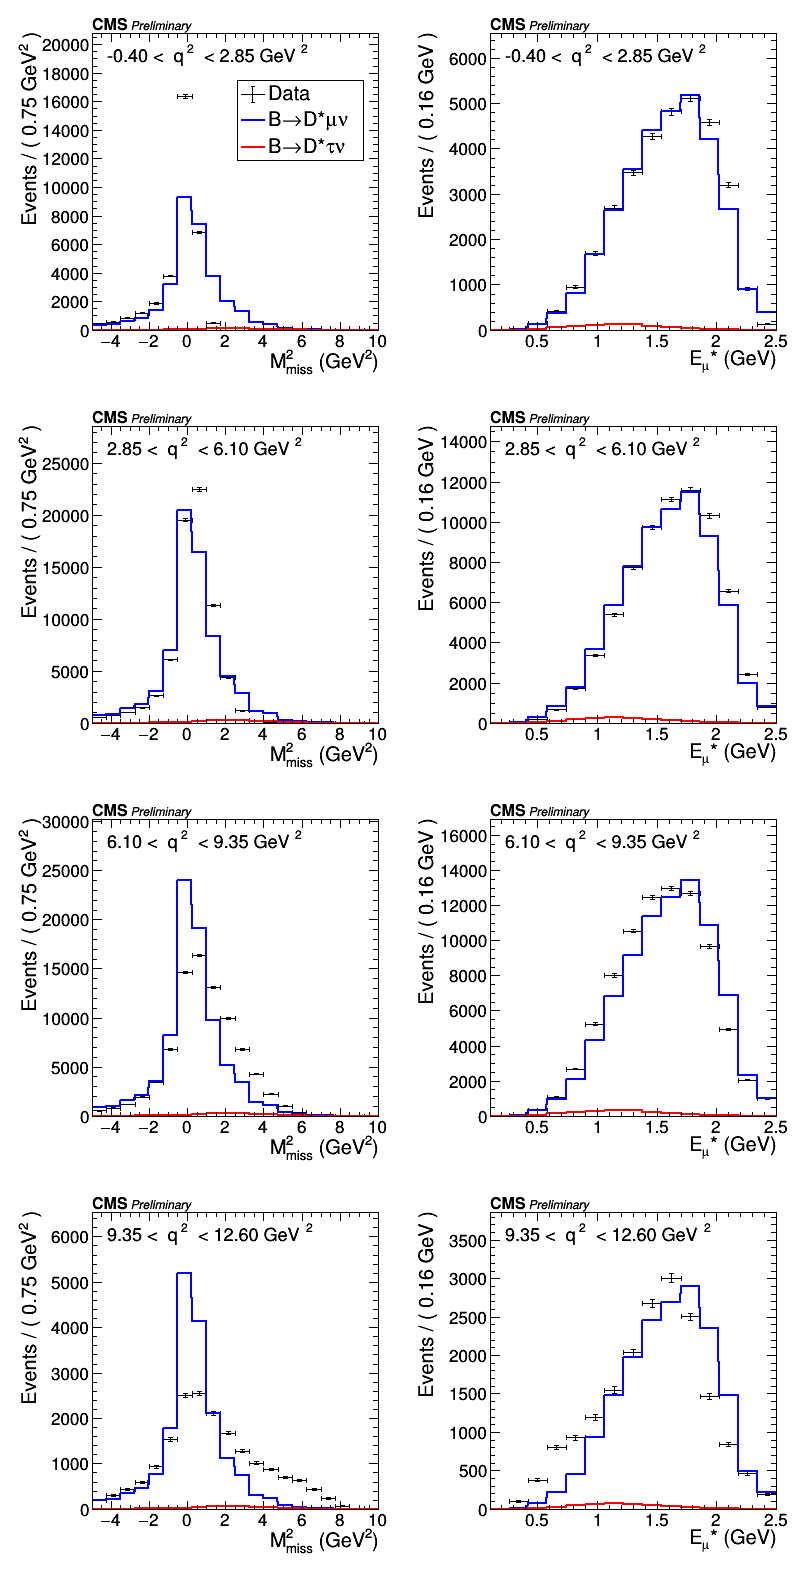

In [24]:
q2_edges = np.linspace(binning['q2'][1], binning['q2'][2], 1+binning['q2'][0], True)

for i_q2 in range(binning['q2'][0]):
    q2_l = q2_edges[i_q2]
    q2_h = q2_edges[i_q2+1]

    q2_txt = '{:.2f} <  q^{{2}}  < {:.2f} GeV^{{2}}'.format(q2_l, q2_h)
    q2_cut = 'q2 > {:.2f} &&  q2 < {:.2f}'.format(q2_l, q2_h)

    for i_v, var in enumerate([M2_miss, Est_mu]):
        frame = var.frame(rf.Title(""))
        aux_data = data.reduce(q2_cut)
        aux_data.plotOn(frame, rf.MarkerStyle(1), rf.Name('Data'))
#         data.plotOn(frame, rf.Cut(q2_cut), rf.MarkerStyle(1))
        
#         pdf_tot.plotOn(frame, rf.LineColor(15), rf.LineWidth(2), rf.LineStyle(9))
        pdf_tot.plotOn(frame, rf.Components('e_mu, e_tau'), rf.ProjWData(rt.RooArgSet(var), data), rf.LineColor(4), rf.LineWidth(2), rf.Name('Mu'))
        pdf_tot.plotOn(frame, rf.Components('e_tau'), rf.ProjWData(rt.RooArgSet(var), data), rf.LineColor(2), rf.LineWidth(2), rf.Name('Tau'))
        
        i_pad = i_q2*N_cols + i_v + 1
        pad = canvas.cd(i_pad)
        pad.SetTopMargin(0.05)
        pad.SetBottomMargin(0.13)
        pad.SetRightMargin(0.03)
        pad.SetLeftMargin(0.22)
        
        frame.Draw()
        CMS_lumi.CMS_lumi(pad, -1, 0, 0.75*1.3, 0.6*1.3)
        
        frame.SetMaximum(1.2*frame.GetMaximum())
        frame.GetYaxis().SetTitleOffset(1.7)
        
        l = rt.TLatex()
        l.SetTextAlign(11)
        l.SetTextSize(0.055)
        l.SetTextFont(42)
        l.DrawLatexNDC(0.26, 0.87, q2_txt)

        if i_pad == 1:
            leg = rt.TLegend(0.6, 0.6, 0.93, 0.82)
            leg.SetTextFont(42)
            leg.SetTextAlign(12)
            leg.SetLineWidth(1)
            leg.SetBorderSize(1)
            leg.AddEntry('Data', 'Data', 'lep')
            leg.AddEntry('Mu', 'B#rightarrowD*#mu#nu', 'l')
            leg.AddEntry('Tau', 'B#rightarrowD*#tau#nu', 'l')
            leg.Draw()

canvas.Draw()

In [25]:
canvas.SaveAs('/Users/olmo/Desktop/RDst_fit.png')